# **Spotify Tracks Regression Project, Predicting Track Popularity**

**Author:** Faryal Rifaz

**Date:** 2025-09-27

**Goal:** Build a clean, reproducible Jupyter Notebook in Markdown and code cells, to predict Spotify track popularity using track metadata and audio features, using regression models and model interpretation

---

## **Project overview and objective**

**Problem statement,** predict the Spotify Popularity score (0 to 100) for a song, given its audio features and metadata, using supervised regression models, this notebook will guide you from data loading to model interpretation, with code cells ready to run

---

## **Import libraries**

In [89]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## **Import libraries**

In [90]:
df = pd.read_csv('Spotify_data.csv')
df.head()

,Unnamed: 0,Track Name,Artists,Album Name,Album ID,Track ID,Popularity,Release Date,Duration (ms),Explicit,...,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,0,Not Like Us,Kendrick Lamar,Not Like Us,5JjnoGJyOxfSZUZtk2rRwZ,6AI3ezQ4o3HUoP6Dhudph3,96,2024-05-04,274192,True,...,0.472,1,-7.001,1,0.0776,0.0107,0.000000,0.1410,0.214,101.061
1,1,Houdini,Eminem,Houdini,6Xuu2z00jxRPZei4IJ9neK,2HYFX63wP3otVIvopRS99Z,94,2024-05-31,227239,True,...,0.887,9,-2.760,0,0.0683,0.0292,0.000002,0.0582,0.889,127.003
2,2,BAND4BAND (feat. Lil Baby),"Central Cee, Lil Baby",BAND4BAND (feat. Lil Baby),4AzPr5SUpNF553eC1d3aRy,7iabz12vAuVQYyekFIWJxD,91,2024-05-23,140733,True,...,0.764,11,-5.241,1,0.2040,0.3590,0.000000,0.1190,0.886,140.113
3,3,I Don't Wanna Wait,"David Guetta, OneRepublic",I Don't Wanna Wait,0wCLHkBRKcndhMQQpeo8Ji,331l3xABO0HMr1Kkyh2LZq,90,2024-04-05,149668,False,...,0.714,1,-4.617,0,0.0309,0.0375,0.000000,0.2320,0.554,129.976
4,4,Pedro,"Jaxomy, Agatino Romero, Raffaella Carrà",Pedro,5y6RXjI5VPR0RyInghTbf1,48lxT5qJF0yYyf2z4wB4xW,89,2024-03-29,144846,False,...,0.936,9,-6.294,1,0.3010,0.0229,0.000001,0.3110,0.844,151.019


## **Check Missing values and Duplicates**

In [91]:
# Missing values summary
missing_counts = df.isna().sum()
missing_pct = (df.isna().mean() * 100).round(2)
missing_summary = pd.DataFrame(
    {"missing_count": missing_counts, "missing_pct": missing_pct}
).sort_values("missing_count", ascending=False)

print("Missing values per column:")
print(missing_summary)
print(f"\nTotal missing cells: {int(missing_counts.sum())}")

# Duplicate rows
dup_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {dup_count}")

if dup_count > 0:
    print("\nPreview of duplicate rows (first 10):")
    dup_preview = df[df.duplicated(keep=False)]
    # Safe sort by all columns to group duplicates together
    try:
        dup_preview = dup_preview.sort_values(list(df.columns))
    except Exception:
        pass
    print(dup_preview.head(10))

Missing values per column:
                  missing_count  missing_pct
Unnamed: 0                    0          0.0
Track Name                    0          0.0
Artists                       0          0.0
Album Name                    0          0.0
Album ID                      0          0.0
Track ID                      0          0.0
Popularity                    0          0.0
Release Date                  0          0.0
Duration (ms)                 0          0.0
Explicit                      0          0.0
External URLs                 0          0.0
Danceability                  0          0.0
Energy                        0          0.0
Key                           0          0.0
Loudness                      0          0.0
Mode                          0          0.0
Speechiness                   0          0.0
Acousticness                  0          0.0
Instrumentalness              0          0.0
Liveness                      0          0.0
Valence                     

## **Data cleaning and preprocessing**


In [92]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


In [93]:
# Convert 'Explicit' to numeric 0/1 (handles bool and yes/no-like strings)
if 'Explicit' in df.columns:
    if pd.api.types.is_bool_dtype(df['Explicit']):
        df['Explicit'] = df['Explicit'].astype(int)
    else:
        normalized = df['Explicit'].astype(str).str.strip().str.lower()
        df['Explicit'] = normalized.map(bool_map).astype('Int64').fillna(0).astype(int)

# Quick check
print("Explicit dtype:", df['Explicit'].dtype)
print(df['Explicit'].value_counts().sort_index())
df.head()

Explicit dtype: int64
Explicit
0    171
1     56
Name: count, dtype: int64


,Track Name,Artists,Album Name,Album ID,Track ID,Popularity,Release Date,Duration (ms),Explicit,External URLs,...,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,Not Like Us,Kendrick Lamar,Not Like Us,5JjnoGJyOxfSZUZtk2rRwZ,6AI3ezQ4o3HUoP6Dhudph3,96,2024-05-04,274192,1,https://open.spotify.com/track/6AI3ezQ4o3HUoP6...,...,0.472,1,-7.001,1,0.0776,0.0107,0.000000,0.1410,0.214,101.061
1,Houdini,Eminem,Houdini,6Xuu2z00jxRPZei4IJ9neK,2HYFX63wP3otVIvopRS99Z,94,2024-05-31,227239,1,https://open.spotify.com/track/2HYFX63wP3otVIv...,...,0.887,9,-2.760,0,0.0683,0.0292,0.000002,0.0582,0.889,127.003
2,BAND4BAND (feat. Lil Baby),"Central Cee, Lil Baby",BAND4BAND (feat. Lil Baby),4AzPr5SUpNF553eC1d3aRy,7iabz12vAuVQYyekFIWJxD,91,2024-05-23,140733,1,https://open.spotify.com/track/7iabz12vAuVQYye...,...,0.764,11,-5.241,1,0.2040,0.3590,0.000000,0.1190,0.886,140.113
3,I Don't Wanna Wait,"David Guetta, OneRepublic",I Don't Wanna Wait,0wCLHkBRKcndhMQQpeo8Ji,331l3xABO0HMr1Kkyh2LZq,90,2024-04-05,149668,0,https://open.spotify.com/track/331l3xABO0HMr1K...,...,0.714,1,-4.617,0,0.0309,0.0375,0.000000,0.2320,0.554,129.976
4,Pedro,"Jaxomy, Agatino Romero, Raffaella Carrà",Pedro,5y6RXjI5VPR0RyInghTbf1,48lxT5qJF0yYyf2z4wB4xW,89,2024-03-29,144846,0,https://open.spotify.com/track/48lxT5qJF0yYyf2...,...,0.936,9,-6.294,1,0.3010,0.0229,0.000001,0.3110,0.844,151.019


## **Select features (independent variables) and target (dependent variable)**

In [94]:

y = df['Popularity']

# Drop non-numeric and target columns for features
cols_to_drop = ['Popularity', 'Track Name', 'Artists', 'Album Name', 'Album ID', 'Track ID', 'Release Date', 'External URLs']
X = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore') \
    .select_dtypes(include=[np.number])

print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (227, 13), y shape: (227,)


## **Split into train and test sets**

In [95]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## **Create and train model**

In [96]:

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## **Predictions**

In [97]:

y_pred = model.predict(X_test)

## **Visualize model performance**

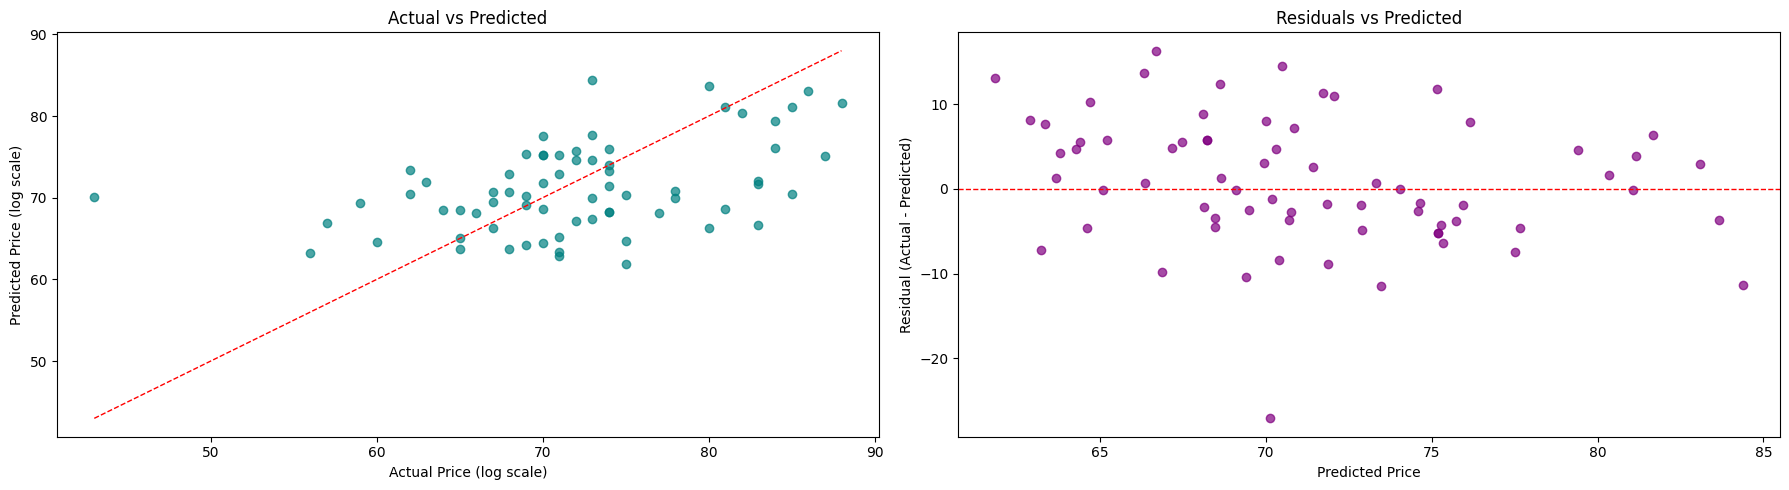

In [98]:


fig, axes = plt.subplots(1, 2, figsize=(18,5))

# 1) Actual vs Predicted
axes[0].scatter(y_test, y_pred, alpha=0.7, color="teal")
mn = min(y_test.min(), y_pred.min())
mx = max(y_test.max(), y_pred.max())
axes[0].plot([mn, mx], [mn, mx], 'r--', linewidth=1)
axes[0].set_xlabel('Actual Price (log scale)')
axes[0].set_ylabel('Predicted Price (log scale)')
axes[0].set_title('Actual vs Predicted')

# 2) Residuals plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.7, color="purple")
axes[1].axhline(0, color='r', linestyle='--', linewidth=1)
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title('Residuals vs Predicted')

plt.tight_layout()
plt.show()


## **Evaluation**

In [99]:


from sklearn.metrics import mean_absolute_error, mean_squared_error 
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# coefficients
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)


R2 Score: 0.1286596957381212
MAE: 5.989075905964436
RMSE: 7.587221308206038
                  Coefficient
Duration (ms)       -0.000009
Explicit             7.022615
Danceability         0.398608
Energy              -1.828771
Key                  0.287410
Loudness             0.897121
Mode                 1.062612
Speechiness         -9.803804
Acousticness       -10.313566
Instrumentalness     5.854804
Liveness            -8.697049
Valence             -5.633739
Tempo               -0.036381


---